In [1]:
import os, platform, pprint, sys
import fastai
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

from fastai.tabular.data import TabularDataLoaders
from fastai.tabular.all import FillMissing, Categorify, Normalize, tabular_learner, accuracy, ClassificationInterpretation, ShowGraphCallback


seed: int = 14


# set up pretty printer for easier data evaluation
pretty = pprint.PrettyPrinter(indent=4, width=30).pprint


# declare file paths for the data we will be working on
file_path_1: str = '../data/prepared/baseline/Benign_vs_DDoS.csv'
file_path_2: str = '../data/prepared/timebased/Benign_vs_DDoS.csv'
dataPath   : str = './models'


# print library and python versions for reproducibility
print(
    f'''
    python:\t{platform.python_version()}

    \tfastai:\t\t{fastai.__version__}
    \tmatplotlib:\t{mpl.__version__}
    \tnumpy:\t\t{np.__version__}
    \tpandas:\t\t{pd.__version__}
    \tsklearn:\t{sklearn.__version__}
    '''
)


    python:	3.7.10

    	fastai:		2.4.1
    	matplotlib:	3.3.4
    	numpy:		1.20.3
    	pandas:		1.2.5
    	sklearn:	0.24.2
    


In [2]:
if file_path_1[0] == '.' and file_path_1[1] == '.':
    filePathClean: str = file_path_1[17::]
    pickleDump: str = f'../data/cache/{filePathClean}.pickle'
pickleDump

'../data/cache/baseline/Benign_vs_DDoS.csv.pickle'

In [3]:
if os.path.exists(pickleDump):
    print('True')

True


In [4]:
def load_data(filePath: str) -> pd.DataFrame:
    '''
        Loads the Dataset from the given filepath and caches it for quick access in the future
        Function will only work when filepath is a .csv file
        After the data is loaded, the benign samples are split and saved in a list
        the malicious samples are split and saved in a dictionary of lists indexed by attack type
        only the top million malicious samples are kept
    '''

    # slice off the ./CSV/ from the filePath
    if filePath[0] == '.' and filePath[1] == '.':
        filePathClean: str = filePath[17::]
        pickleDump: str = f'../data/cache/{filePathClean}.pickle'
    else:
        pickleDump: str = f'../data/cache/{filePath}.pickle'
    
    print(f'Loading Dataset: {filePath}')
    print(f'\tTo Dataset Cache: {pickleDump}\n')
    
    # check if data already exists within cache
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
        
    # if not, load data and cache it
    else:
        df = pd.read_csv(filePath, low_memory=True)
        df.to_pickle(pickleDump)

    
    return df

In [5]:
baseline_df : pd.DataFrame = load_data(file_path_1)
timebased_df: pd.DataFrame = load_data(file_path_2)

Loading Dataset: ../data/prepared/baseline/Benign_vs_DDoS.csv
	To Dataset Cache: ../data/cache/baseline/Benign_vs_DDoS.csv.pickle

Loading Dataset: ../data/prepared/timebased/Benign_vs_DDoS.csv
	To Dataset Cache: ../data/cache/timebased/Benign_vs_DDoS.csv.pickle



In [6]:
def run_experiment(df, name):
    '''
        Run binary classification on a given dataframe, saving the model as {name}.model
    '''
    dep_var: str = 'Label'
    unused_categories: list = []
    selected_features = list(set(df) - set(unused_categories) - set([dep_var]))

    procs = [FillMissing, Categorify, Normalize]

    tdl = TabularDataLoaders.from_df(df, path=dataPath, y_names=dep_var, cat_names=[], cont_names=selected_features, procs=procs)

    model = tabular_learner(tdl, layers=[50, 28], metrics=accuracy, cbs=ShowGraphCallback)
    model.fit_one_cycle(10)
    model.save(f'{name}.model')


    loss, acc = model.validate()
    print('loss {}: accuracy: {:.2f}%'.format(loss, acc*100))

    # preds, y, decoded, losses = model.get_preds(with_loss=True, with_decoded=True)

    interp = ClassificationInterpretation.from_learner(model)
    # interp = ClassificationInterpretation(model, preds, y, losses)
    interp.plot_confusion_matrix()

epoch,train_loss,valid_loss,accuracy,time
0,0.013146,0.012466,0.997827,00:22
1,0.003410,0.011662,0.997871,00:21
2,0.012356,0.006976,0.998603,00:21
3,0.005316,0.017203,0.996851,00:21
4,0.005939,0.005530,0.999046,00:21
5,0.005416,0.005670,0.998869,00:21
6,0.006401,0.008361,0.998270,00:21
7,0.006039,0.004265,0.999002,00:21
8,0.004036,0.009634,0.998980,00:24
9,0.003021,0.004045,0.999113,00:22


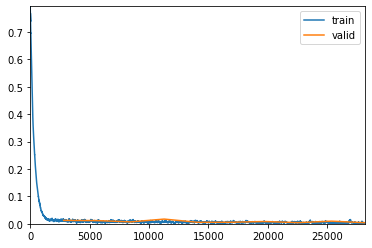

loss 0.004044621717184782: accuracy: 99.91%


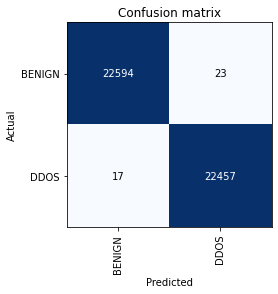

In [7]:
run_experiment(baseline_df, 'ddos_vs_benign_baseline')

epoch,train_loss,valid_loss,accuracy,time
0,0.257838,0.307853,0.797254,00:22
1,0.225109,0.445419,0.782351,00:23
2,0.200883,0.458996,0.798740,00:23
3,0.189669,0.349972,0.842807,00:22
4,0.161347,0.603042,0.800093,00:23
5,0.155599,0.769889,0.802377,00:23
6,0.137159,0.431987,0.857555,00:23
7,0.137327,0.395622,0.846688,00:23
8,0.137546,0.542465,0.836220,00:22
9,0.130640,0.537780,0.834180,00:22


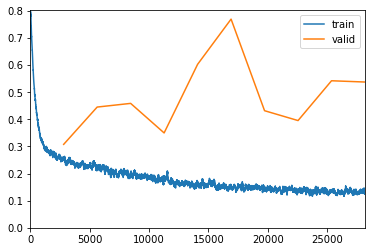

loss 0.5377804040908813: accuracy: 83.42%


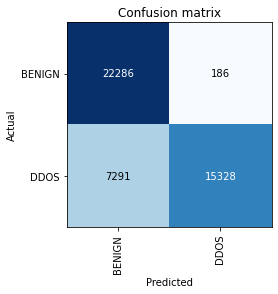

In [8]:
run_experiment(timebased_df, 'ddos_vs_benign_timebased')